In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import  classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline 

In [49]:
import importlib
import ids_common
importlib.reload(ids_common)

<module 'ids_common' from 'd:\\stuff\\univ\\ids\\ids_common.py'>

In [41]:
SEED = random.randint(0, 42424242)
SEED = 42
print(f'SEED = {SEED}')

SEED = 42


In [24]:
class Model:
    def __init__(self, name:str, model, params:dict=None) -> None:
        self.name = name
        self.params = params
        self.model = model

class CompositeModel:
    def __init__(self, detector, classifier) -> None:
        self.detector = detector
        self.classifier = classifier

In [51]:
detectors = [
      Model('DT_best', 
            DecisionTreeClassifier(**{'criterion': 'entropy', 'max_depth': 16}, 
                                    random_state=SEED)),
      Model('RF_best',
            RandomForestClassifier(**{'criterion': 'entropy', 'max_depth': 128, 'max_features': 'log2', 'n_estimators': 100}, 
                                   random_state=SEED)
            )
#     Model('DT_grid_search', 
#           DecisionTreeClassifier(random_state=SEED),
#           params={'criterion':['gini','entropy', 'log_loss'],
#                 'max_depth':[8,16,32,64,128,256]}),
]

classifiers = [
      Model('DT_best', 
            DecisionTreeClassifier(**{'criterion': 'entropy', 'max_depth': 16}, 
                                    random_state=SEED)
            ),
      Model('RF_best',
            RandomForestClassifier(**{'criterion': 'entropy', 'max_depth': 128, 'max_features': 'log2', 'n_estimators': 100}, 
                                   random_state=SEED),
            )
#     Model('DT_grid_search', 
#           DecisionTreeClassifier(random_state=SEED),
#           params={'criterion':['gini','entropy', 'log_loss'],
#                 'max_depth':[8,16,32,64,128,256]}),
]

In [52]:
df = pd.read_csv('./dataset/Edge-IIoTset-dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv', low_memory=False)
ids_common.prepare_dataset_v1(df, verbose=True)
df.info()

Before: dropna: NA: 0, DUPS: 309530
After: dropna: NA: 0, DUPS: 0
<class 'pandas.core.frame.DataFrame'>
Index: 1909671 entries, 0 to 2219193
Data columns (total 89 columns):
 #   Column                                                                                                Dtype   
---  ------                                                                                                -----   
 0   arp.opcode                                                                                            float64 
 1   arp.hw.size                                                                                           float64 
 2   icmp.checksum                                                                                         float64 
 3   icmp.seq_le                                                                                           float64 
 4   icmp.unused                                                                                           float64 
 5   http.cont

In [53]:
df_train_global, df_test_global = ids_common.ds_split(df, seed=SEED)
print(f'df_train_global={df_train_global.shape}')
print(f'df_test_global={df_test_global.shape}')

X_train_detection, X_test_detection, y_train_detection, y_test_detection = ids_common.ds_detection_split(df_train_global, seed=SEED)
print(f'X_train_detection={X_train_detection.shape} y_train_detection={y_train_detection.shape}')
print(f'X_test_detection={X_test_detection.shape}   y_test_detection={y_test_detection.shape}')

X_train_classification, X_test_classification, y_train_classification, y_test_classification = ids_common.ds_classification_split(df_train_global, seed=SEED)
print(f'X_train_classification={X_train_classification.shape} y_train_classification={y_train_classification.shape}')
print(f'X_test_classification={X_test_classification.shape}   y_test_classification={y_test_classification.shape}')

X_train_15, X_test_15, y_train_15, y_test_15 = ids_common.dataset_split_15classes(df_train_global, seed=SEED)
print(f'X_train_15={X_train_15.shape} y_train_15={y_train_15.shape}')
print(f'X_test_15={X_test_15.shape}   y_test_15={y_test_15.shape}')

df_train_global=(1527736, 89)
df_test_global=(381935, 89)
X_train_detection=(1222188, 87) y_train_detection=(1222188,)
X_test_detection=(305548, 87)   y_test_detection=(305548,)
X_train_classification=(349230, 87) y_train_classification=(349230,)
X_test_classification=(87308, 87)   y_test_classification=(87308,)
X_train_15=(1069415, 87) y_train_15=(1069415,)
X_test_15=(458321, 87)   y_test_15=(458321,)


In [54]:
def train_models(models, X_train, y_train, X_test, y_test):
    for m in models:

        print('$'*80)
        print('Model:', m.name)

        if m.params:
            grid_search = GridSearchCV(m.model, m.params, cv=2, verbose=3)
            grid_search.fit(X_train, y_train)
            print('[GS] Tuned:')
            print('[GS] Parms: ', grid_search.best_params_)
            print('[GS] Score:', grid_search.best_score_)

            m.model = grid_search.best_estimator_
    
        m.model.fit(X_train, y_train)

        y_train_predict = m.model.predict(X_train)
        y_test_predict = m.model.predict(X_test)

        
        ids_common.report(y_train, 
                          y_train_predict, 
                          y_test,
                          y_test_predict)

        ids_common.plot_cm(y_test, y_test_predict)

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Model: DT_best
TRAIN:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    872958
           1       1.00      0.90      0.94    349230

    accuracy                           0.97   1222188
   macro avg       0.98      0.95      0.96   1222188
weighted avg       0.97      0.97      0.97   1222188

TEST:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    218240
           1       1.00      0.89      0.94     87308

    accuracy                           0.97    305548
   macro avg       0.98      0.95      0.96    305548
weighted avg       0.97      0.97      0.97    305548



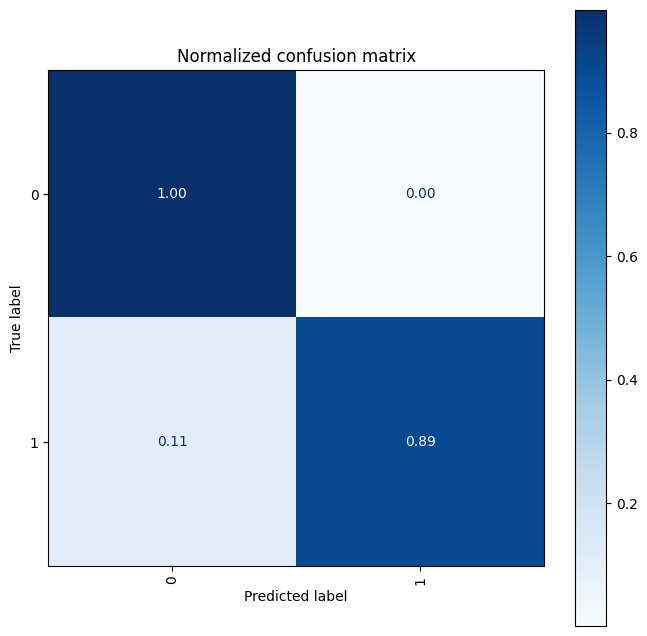

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Model: RF_best
TRAIN:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    872958
           1       0.99      0.99      0.99    349230

    accuracy                           0.99   1222188
   macro avg       0.99      0.99      0.99   1222188
weighted avg       0.99      0.99      0.99   1222188

TEST:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97    218240
           1       0.95      0.91      0.93     87308

    accuracy                           0.96    305548
   macro avg       0.96      0.95      0.95    305548
weighted avg       0.96      0.96      0.96    305548



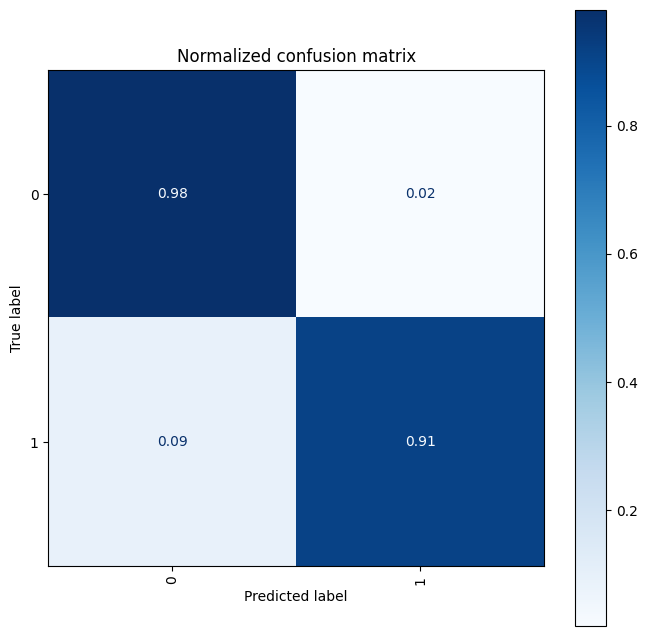

In [55]:
train_models(detectors, 
             X_train_detection, y_train_detection,
             X_test_detection, y_test_detection)

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Model: DT_best
TRAIN:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.94      0.97     15377
            DDoS_HTTP       0.69      0.93      0.79     31068
            DDoS_ICMP       1.00      1.00      1.00     43481
             DDoS_TCP       1.00      1.00      1.00     32040
             DDoS_UDP       1.00      1.00      1.00     77802
       Fingerprinting       0.99      0.72      0.83       545
                 MITM       1.00      1.00      1.00       229
             Password       0.75      0.88      0.81     31957
        Port_Scanning       0.86      1.00      0.92     12785
           Ransomware       1.00      0.89      0.94      6201
        SQL_injection       0.89      0.75      0.81     32529
            Uploading       0.97      0.63      0.77     23557
Vulnerability_scanner       1.00      0.96      0.98     32017
              

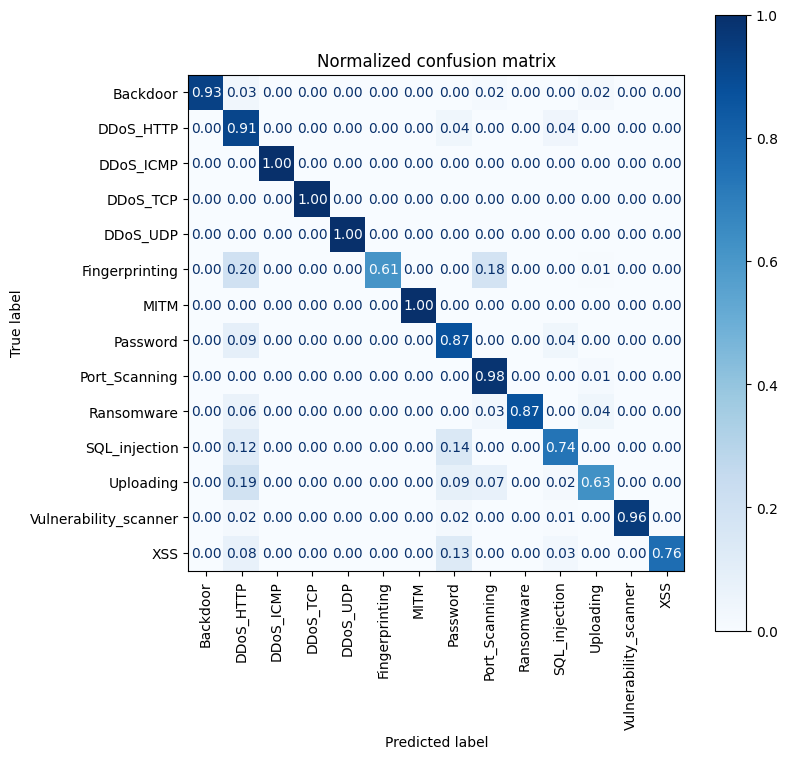

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Model: RF_best
TRAIN:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.99      1.00     15377
            DDoS_HTTP       0.97      0.98      0.98     31068
            DDoS_ICMP       1.00      1.00      1.00     43481
             DDoS_TCP       1.00      1.00      1.00     32040
             DDoS_UDP       1.00      1.00      1.00     77802
       Fingerprinting       0.99      0.97      0.98       545
                 MITM       0.97      1.00      0.98       229
             Password       0.99      0.99      0.99     31957
        Port_Scanning       1.00      1.00      1.00     12785
           Ransomware       1.00      0.99      0.99      6201
        SQL_injection       0.99      0.99      0.99     32529
            Uploading       0.98      0.98      0.98     23557
Vulnerability_scanner       1.00      1.00      1.00     32017
              

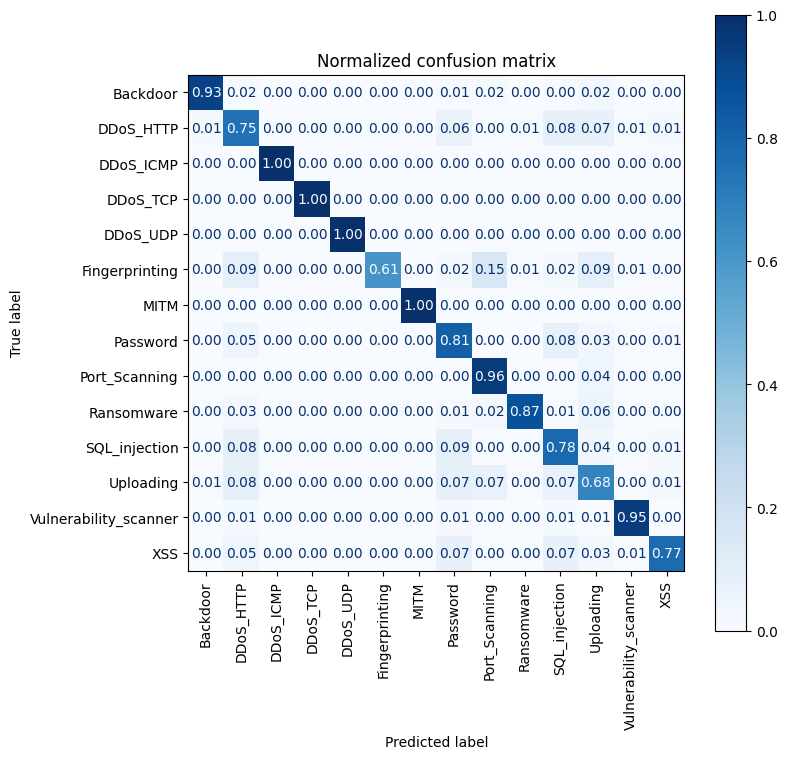

In [56]:
train_models(classifiers, 
             X_train_classification, y_train_classification,
             X_test_classification, y_test_classification)

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Model: DT_best
TRAIN:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.93      0.96     13455
            DDoS_HTTP       0.93      0.68      0.79     27185
            DDoS_ICMP       1.00      1.00      1.00     38046
             DDoS_TCP       1.00      1.00      1.00     28035
             DDoS_UDP       1.00      1.00      1.00     68077
       Fingerprinting       0.99      0.71      0.83       477
                 MITM       1.00      0.99      1.00       200
               Normal       0.96      1.00      0.98    763838
             Password       1.00      0.73      0.84     27962
        Port_Scanning       0.85      1.00      0.92     11187
           Ransomware       1.00      0.89      0.94      5426
        SQL_injection       0.96      0.71      0.82     28463
            Uploading       0.97      0.63      0.77     20612
Vulnerability_

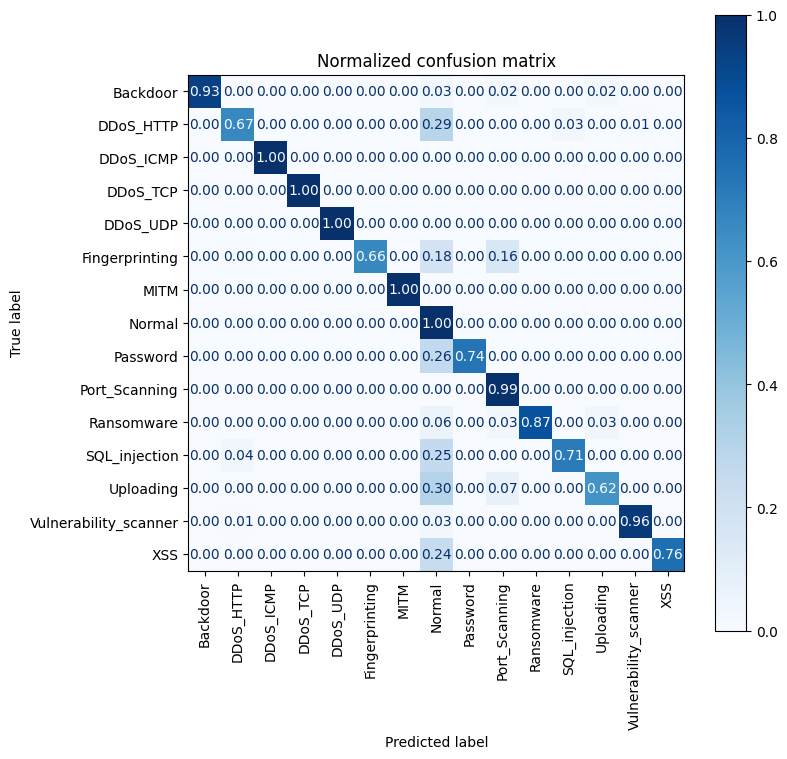

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Model: RF_best
TRAIN:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.99      0.99     13455
            DDoS_HTTP       0.96      0.91      0.94     27185
            DDoS_ICMP       1.00      1.00      1.00     38046
             DDoS_TCP       1.00      1.00      1.00     28035
             DDoS_UDP       1.00      1.00      1.00     68077
       Fingerprinting       0.96      0.94      0.95       477
                 MITM       1.00      0.99      1.00       200
               Normal       0.99      1.00      1.00    763838
             Password       0.99      0.97      0.98     27962
        Port_Scanning       1.00      1.00      1.00     11187
           Ransomware       0.99      0.98      0.98      5426
        SQL_injection       0.99      0.97      0.98     28463
            Uploading       0.97      0.93      0.95     20612
Vulnerability_

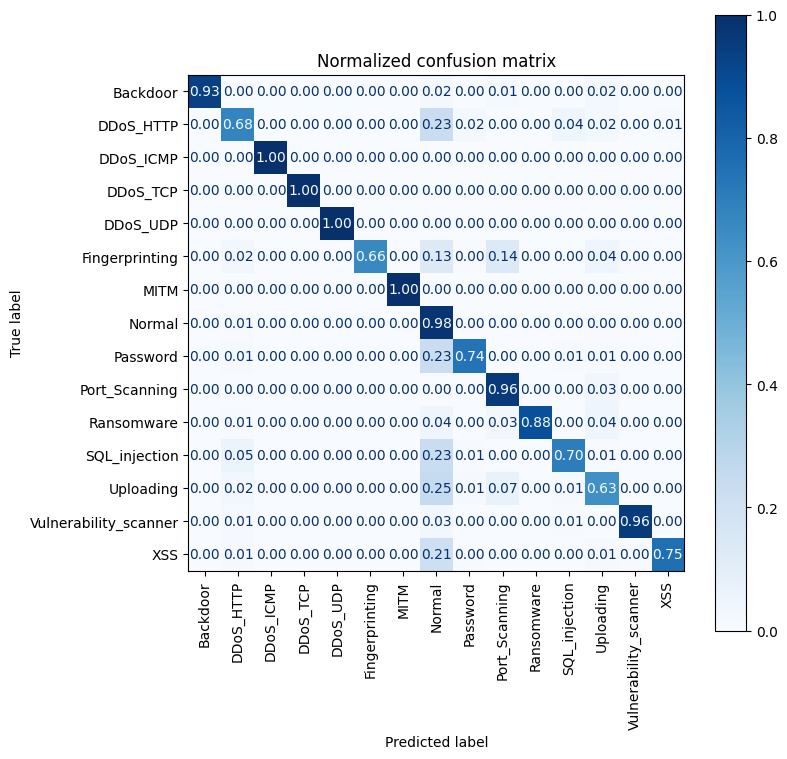

In [57]:
train_models(classifiers, 
             X_train_15, y_train_15,
             X_test_15, y_test_15)